In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

%matplotlib inline

DATA_RAW_PATH = os.path.abspath(os.path.join(
    os.getcwd(), "../data/raw"))
DATA_OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../data/output"))

# To get the example images that below worked on please first run the download_assets.py file

#### Align an image to a template.
![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_image-alignment-using-opencv.jpg "Image Alignment")

#### Theory

1. A **Homography** transforms a square to arbitrary quad. 

![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_motion-models.jpg "Motion Models")

#### Theory

2. Images of two planes are related by a **Homography**
3. We need **4 corresponding points** to estimate Homography


!["Homography Example"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_homography-example.jpg)

#### Step 1: Read Tempalate and Scanned Image

In [38]:
# Read reference image
ref_path = f"{DATA_RAW_PATH}/form.jpg"
print("Reading reference image:", ref_path)
img_ref_bgr = cv2.imread(ref_path, cv2.IMREAD_COLOR)
img_ref_rgb = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2RGB)

# Read image to be aligned
img_path = f"{DATA_RAW_PATH}/scanned-form.jpg"
print("Reading image to align:", img_path)
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

Reading reference image: /Users/merteldem1r/Documents/OpenCV-Bootcamp/7-Image-Features-and-Alignment/data/raw/form.jpg
Reading image to align: /Users/merteldem1r/Documents/OpenCV-Bootcamp/7-Image-Features-and-Alignment/data/raw/scanned-form.jpg


Text(0.5, 1.0, 'Scanned Form')

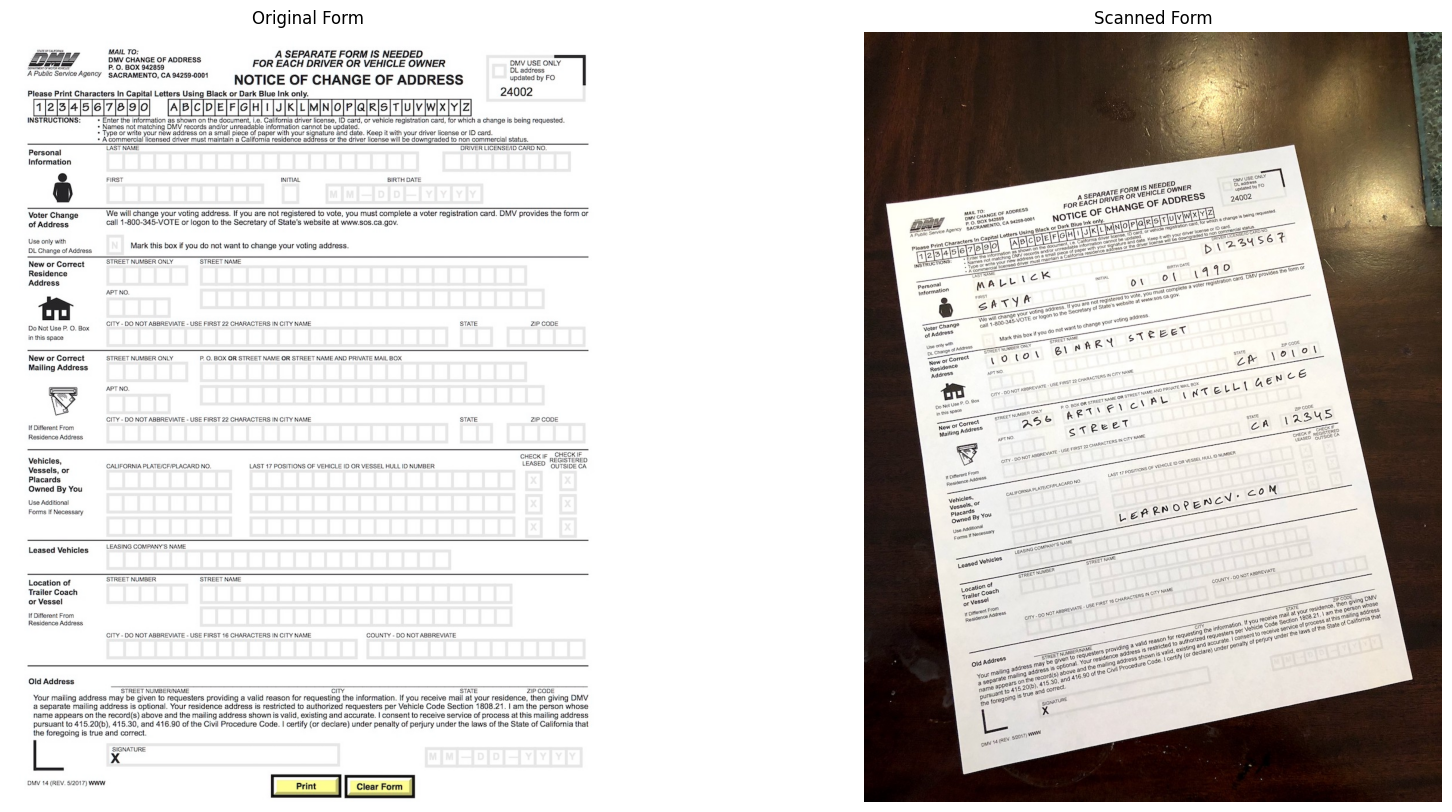

In [39]:
# Display Images

plt.figure(figsize=[20, 10]); 
plt.subplot(121); plt.axis('off'); plt.imshow(img_ref_bgr); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(img_rgb); plt.title("Scanned Form")

#### Step 2: Find keypoints in both Images

Think of keypoints as corner points that are stable under image transformations

#### Feature matching using **ORB** algorithm

**ORB** is a fusion of **FAST keypoint detector** and BRIEF descriptor with some added features to improve the performance. FAST is Features from Accelerated Segment Test used to detect features from the provided image. It also uses a pyramid to produce multiscale-features. Now it doesn’t compute the orientation and descriptors for the features, so this is where BRIEF comes in the role.

#### ORB Workflow (Under the Hood):

1. Keypoint Detection — FAST:

- FAST = Features from Accelerated Segment Test
- Looks for corners in the image by comparing pixel brightness around a circle.
- It's very fast but not rotation-invariant by itself.

2. Orientation Assignment:

- ORB adds orientation to each keypoint by computing the intensity centroid, making it rotation-invariant.

3. Descriptor Extraction — BRIEF:

- BRIEF = Binary Robust Independent Elementary Features

- Describes the patch around a keypoint as a binary string.

- ORB rotates BRIEF according to the keypoint orientation → Rotated BRIEF.

4. Feature Matching (done later):

- Compares descriptors using Hamming distance (because descriptors are binary).

- Matches are used for tasks like image alignment, object detection, or structure from motion.


In [40]:
img_ref_gry = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
img_gry = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints_ref, descriptors_ref = orb.detectAndCompute(img_ref_gry, None)
keypoints_img, descriptors_img = orb.detectAndCompute(img_gry, None)

# KeyPoint:	A distinctive point in the image (like a corner).
# Descriptor: A compact vector (binary in ORB) representing the keypoint’s neighborhood.

# image display
img_ref_display_keypoints = cv2.drawKeypoints(img_ref_rgb, keypoints_ref, outImage=np.array(
    []), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_display_keypoints = cv2.drawKeypoints(img_rgb, keypoints_img, outImage=np.array(
    []), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

##### Keypoint: A visually unique spot (e.g., corner, edge)
##### Descriptor: A numeric vector describing the pattern of the pixels around that keypoint
##### Matching: Comparing descriptors from two images to find similar areas


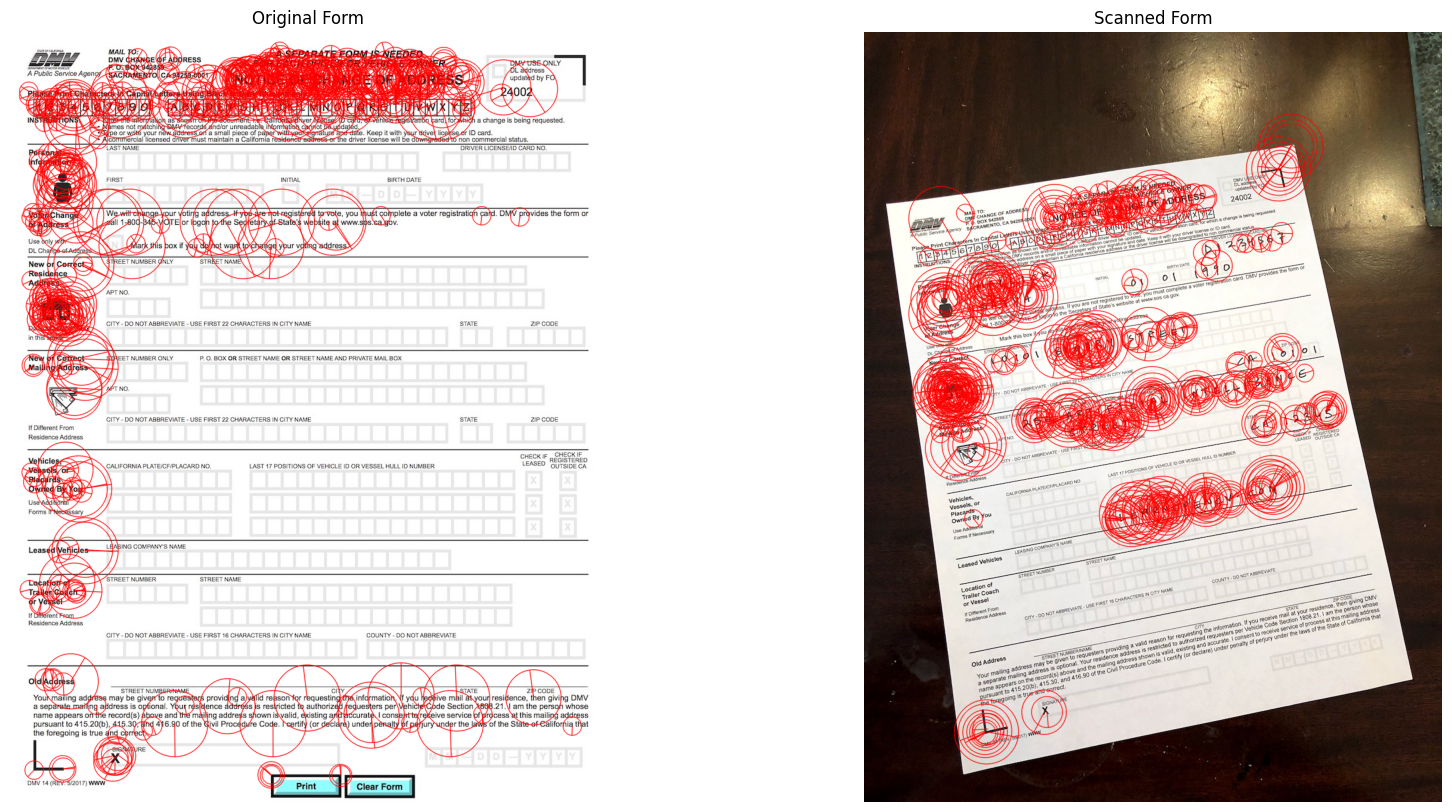

In [41]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(img_ref_display_keypoints); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(img_display_keypoints); plt.title("Scanned Form");

#### Step 3 : Match keypoints in the two image

In [42]:
matcher = cv2.DescriptorMatcher_create(
    cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

matches = list(matcher.match(descriptors_ref, descriptors_img, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

Text(0.5, 1.0, 'Matches Form')

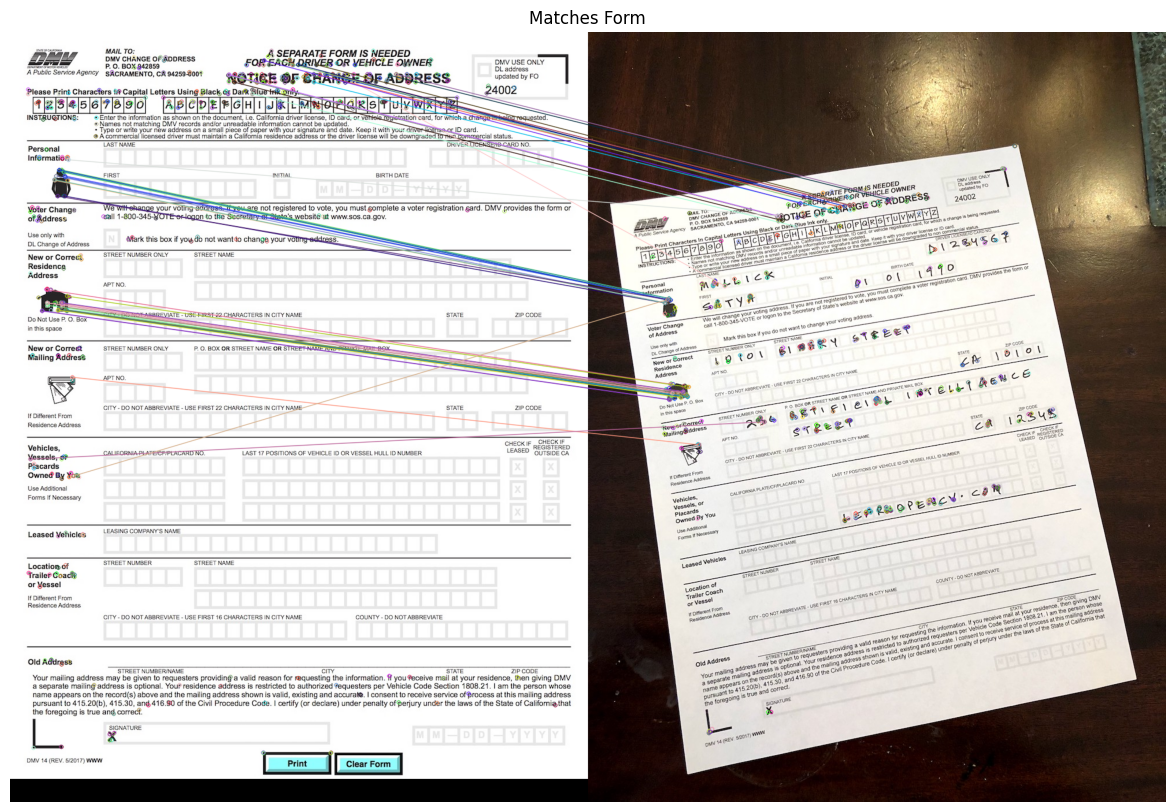

In [43]:
img_matches = cv2.drawMatches(img_ref_rgb, keypoints_ref, img_rgb, keypoints_img, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(img_matches);plt.axis("off");plt.title("Matches Form")

#### Step 4: Find Homography

Homography is a mathematical transformation that maps points from one image plane to another.

It describes how the whole 2D plane is distorted, rotated, scaled, translated, or skewed between two images.

In [44]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints_ref[match.queryIdx].pt
    points2[i, :] = keypoints_img[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

#### Step 5: Warp image

Text(0.5, 1.0, 'Scanned Form')

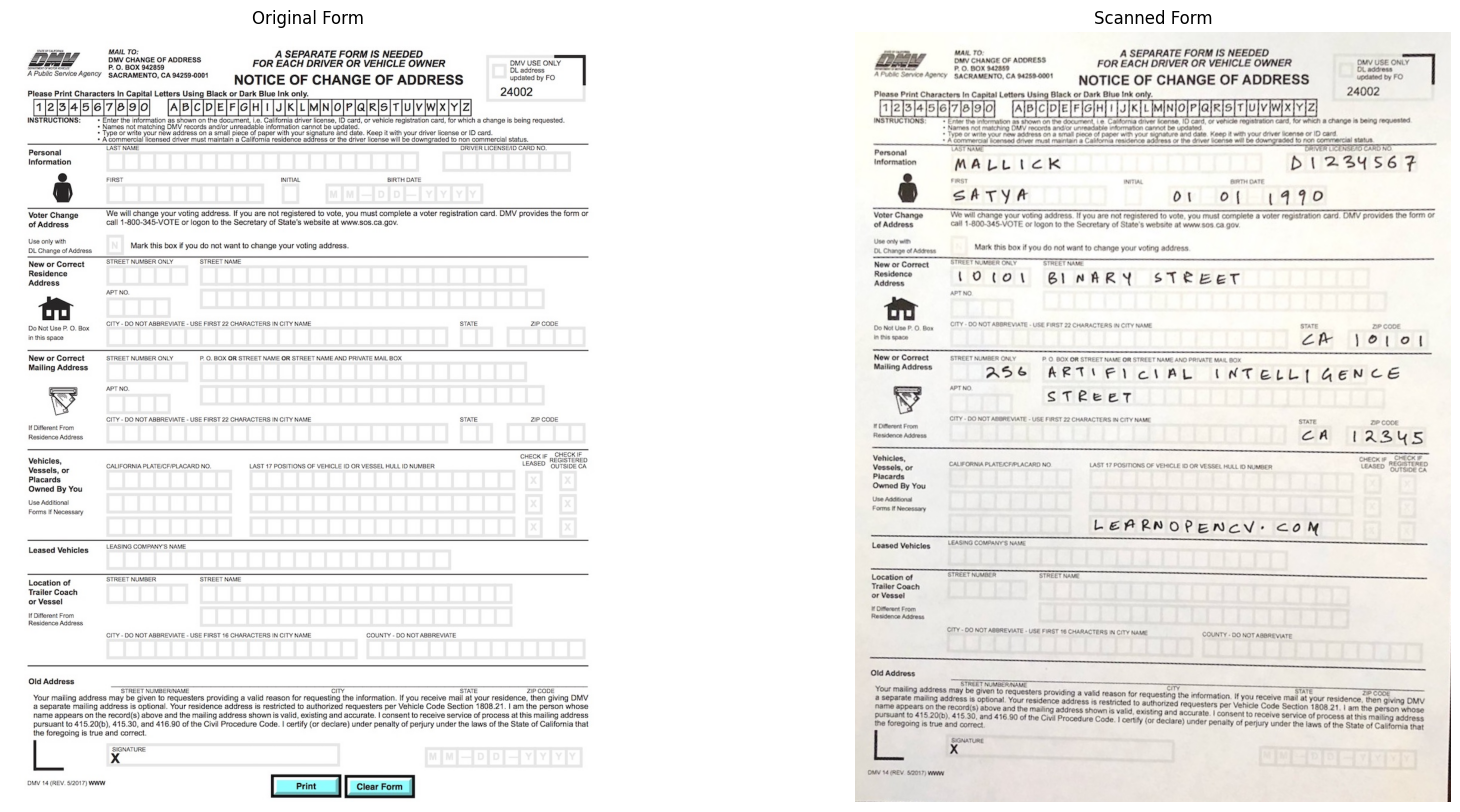

In [45]:
# Use homography to warp image
height, width, channels = img_ref_rgb.shape
im2_reg = cv2.warpPerspective(img_rgb, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(img_ref_rgb);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")